In [353]:
from itertools import chain, combinations
from typing import Optional
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

_Array = np.ndarray

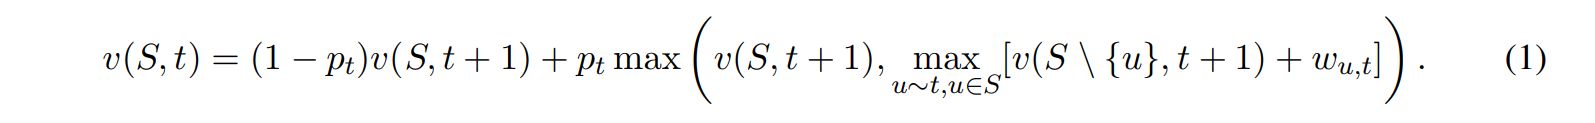

In [12]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    return list(map(set, powerset))

def diff(S, u):
    return S.difference(set([u]))

In [29]:
def cache_stochastic_opt(A: _Array, p: _Array, m: int, n: int):
    '''
    Computes the value-to-go for all timesteps t=1..[n] and for
    all subsets S of offline nodes {1, ..., [m]}, according to
    online arrival probabilities [p] and underlying graph
    adjacency matrix [A].
    '''
    def _neighbor_max_argmax(A: _Array, S: set, t: int):
        argmax = -1
        max_val = cache[(frozenset(S), t + 1)][0]
        for u in S:
            val = cache[(frozenset(diff(S, u)), t + 1)][0] + A[m + t, u]
            if val > max_val:
                argmax = u
                max_val = val

        return max_val, argmax
        
    def _value_to_go(A: _Array, S: set, t: int):
        '''
        Computes the value-to-go of unmatched node set [S] starting
        at online node [t] for the graph defined by the adjacency matrix
        [A], caching all intermediate results.
        '''
        S_key = frozenset(S)
        if (S_key, t + 1) not in cache:
            cache[(S_key, t + 1)] = _value_to_go(A, S, t + 1)

        S_diffs = [diff(S, u) for u in S]
        for S_diff in S_diffs:
            S_diff_key = frozenset(S_diff)
            if (S_diff_key, t + 1) not in cache:
                cache[(S_diff_key, t + 1)] = _value_to_go(A, S_diff, t + 1)
        
        max_val, argmax = _neighbor_max_argmax(A, S, t)
                
        exp_value_to_go = (1 - p[t]) * cache[(S_key, t + 1)][0] + \
            p[t] * max([cache[(S_key, t + 1)][0], max_val])
                
        return (exp_value_to_go, argmax)
    
    offline_nodes = np.arange(m)
    T = n
    cache = {}
    
    # Set boundary conditions
    for t in np.arange(T):
        cache[(frozenset(), t)] = (0, None)  
    for subset in powerset(offline_nodes):
        cache[frozenset(subset), T] = (0, None)
        
    # Cache all relevant DP quantities
    cache[(frozenset(offline_nodes), 0)] = _value_to_go(A, set(offline_nodes), 0)
    return cache

In [298]:
def one_step_stochastic_opt(
    used_offline_nodes: set,
    A: _Array,
    m: int,
    n: int,
    t: int,
    cache: dict
):

    offline_nodes = set(np.arange(m)).difference(used_offline_nodes)
    
    hint = np.zeros(m + 1)
    hint[-1] = cache[(frozenset(offline_nodes), t + 1)][0]
    for u in offline_nodes:
        hint[u] = cache[(frozenset(diff(offline_nodes, u)), t + 1)][0] + A[m + t, u]
    
    return hint

def stochastic_opt(
    A: _Array,
    coin_flips: _Array,
    m: int,
    n: int,
    cache: Optional[dict] = None
):
    if cache is None:
        cache = cache_stochastic_opt(A, p, m, n)
        
    used_offline_nodes = set()
    owners = np.full(m + n, fill_value=-1)
    total = 0
    
    for t in range(n):
        if coin_flips[t]:
            hint = one_step_stochastic_opt(used_offline_nodes, A, m, n, t, cache)
            choice = np.argmax(hint)
            if choice != m:
                owners[choice] = t + m
                owners[t + m] = choice
                used_offline_nodes.add(choice)
                total += A[choice, t + m]

    return owners
                

def greedy(
    A: _Array,
    coin_flips: _Array,
    m: int,
    n: int
):
    def _mask(used_offline_nodes, adj):
        return [adj[i] if i not in used_offline_nodes else 0 for i in range(m)]
    
    owners = np.full(m + n, fill_value=-1)
    used_offline_nodes = set()
    for t in range(n):
        if coin_flips[t]:
            masked_adj = _mask(used_offline_nodes, A[:m, m + t])
            choice = np.argmax(masked_adj)
            if masked_adj[choice] > 0:
                owners[choice] = t + m
                owners[t + m] = choice
                used_offline_nodes.add(choice)
    return owners

def value_of_owners(
    owners: _Array,
    A: _Array
):
    value = 0
    for i in range(A.shape[0]):
        if owners[i] >= 0:
            value += A[i, owners[i]]
    return value / 2
                
def optimal_matching_value(A: _Array):
    row, col = linear_sum_assignment(A, maximize=True)
    return A[row, col].sum()
    

In [374]:
# m is size of offline node set
# n is size of online node set
m = 16
n = 16

mat = np.random.rand(m, n)
A = np.zeros((m + n, m + n))
A[:m, m:] = mat
A[m:, :m] = mat.T
#print(A)

p = [1 for _ in range(n)]
cache = cache_stochastic_opt(A, p, m, n)
coin_flips = [np.random.binomial(p=p_t, n=1) for p_t in p]
# print(f'Adjacency matrix: \n{A}\n')
#print(f'Arrival coin flips: {coin_flips}')
opt = stochastic_opt(A, coin_flips, m, n, cache)
alg = greedy(A, coin_flips, m, n)
optimal_matching_value(A)

29.81810009294265

In [287]:
value_of_owners(opt, A)

10.760928220420626

In [288]:
value_of_owners(alg, A)

9.687027820869774

In [357]:
 def _symmetrize(adj):
    n, m = adj.shape
    A = np.zeros((n + m, n + m))
    A[:n, n:] = adj
    A[n:, :n] = adj.T
    return A

 def _add_uniform_weights(adj, low, high):
        n, m = adj.shape
        weights = np.random.uniform(
            low=low, high=high, size=(n, m)
        )
        return np.multiply(adj.astype(float), weights)

def _random_er_bipartite_graph(n, m, **kwargs):
    """Random Erdos-Renyi graph."""
    weighted = kwargs.get('weighted', False)
    low = kwargs.get('low', 0.0),
    high = kwargs.get('high', 1.0)
    p = kwargs.get('p', 0.5)

    mat = np.random.binomial(1, p, size=(n, m))
    if weighted:
        mat = _add_uniform_weights(mat, low, high)

    return _symmetrize(mat), mat

def _random_ba_bipartite_graph(n: int, m: int, **kwargs):
    weighted = kwargs.get('weighted', False)
    ba_param = kwargs.get('ba_param', 5)
    low = kwargs.get('low', 0.0),
    high = kwargs.get('high', 1.0)

    ba_graph = nx.barabasi_albert_graph(n + m, ba_param)
    mat = nx.to_numpy_array(ba_graph)[:n, n:]
    if weighted:
        mat = _add_uniform_weights(mat, low, high)
    return _symmetrize(mat), mat

def _random_geometric_bipartite_graph(n: int, m: int, **kwargs):
    ''' Generates a geometric bipartite graph by embedding [n] LHS nodes and [m]
    RHS nodes uniformly in a unit square, and taking pairwise distances to be
    edge weights. Edges with weight below [threshold] are removed, and
    edge weights are scaled by a factor of [scaling] as a final step.
    '''

    threshold = kwargs.get('threshold', 0.25)
    scaling = kwargs.get('scaling', 1.0)
    partition = kwargs.get('partition', 5)
    width = 1 / partition
    power = kwargs.get('power', 1)

    red_rates = np.random.power(power, (partition, partition))
    blue_rates = np.random.power(power, (partition, partition))
    red_rates = (red_rates / np.sum(red_rates)).flatten()
    blue_rates = (blue_rates / np.sum(blue_rates)).flatten()

    bounds = [
        ((1 - (i + 1) * width, 1 - i * width),
         (1 - (j + 1) * width, 1 - j * width))
        for j in np.arange(partition)
        for i in np.arange(partition)
    ]

    red_ind = np.random.choice(
        np.arange(partition * partition), n, p=red_rates)
    blue_ind = np.random.choice(
        np.arange(partition * partition), m, p=blue_rates)

    red = []
    blue = []

    for i in red_ind:
        red.append(
            [np.random.uniform(*bounds[i][0]),
             np.random.uniform(*bounds[i][1])]
        )
    for i in blue_ind:
        blue.append(
            [np.random.uniform(*bounds[i][0]),
             np.random.uniform(*bounds[i][1])]
        )

    red = np.array(red)
    blue = np.array(blue)

    # n x m matrix with pairwise euclidean distances
    dist = np.linalg.norm(red[:, None, :] - blue[None, :, :], axis=-1)
    dist[dist < threshold] = 0
    return scaling * _symmetrize(dist), scaling * dist

def _random_complete_bipartite_graph(n: int, m: int, **kwargs):
    mat = np.random.rand(n, m)
    return _symmetrize(mat), mat
        
def _random_bipartite_graph(n: int, m: int, graph_type: str, **kwargs):
    if graph_type == 'ER':
        return _random_er_bipartite_graph(n, m, **kwargs)
    elif graph_type == 'BA':
        return _random_ba_bipartite_graph(n, m, **kwargs)
    elif graph_type == 'GEOM':
        return _random_geometric_bipartite_graph(n, m, **kwargs)
    else:
        return _complete_random_graph(n, m, **kwargs)
    

In [376]:
def benchmark(m: int, n: int, p: _Array, graph_type: str, iterations: Optional[int] = 500, **kwargs):
    opt_ratios = []
    alg_ratios = []
    
    for i in range(iterations):
        A, mat = _random_bipartite_graph(m, n, graph_type, **kwargs)
            
        coin_flips = [np.random.binomial(p=p_t, n=1) for p_t in p]
        cache = cache_stochastic_opt(A, p, m, n)
        
        opt = value_of_owners(stochastic_opt(A, coin_flips, m, n, cache), A)
        alg = value_of_owners(greedy(A, coin_flips, m, n), A)
        
        index = [i for i in range(n) if coin_flips[i] == 0]
        mat[:, index] = 0
        offline_opt = optimal_matching_value(mat)
        opt_ratios.append(opt / offline_opt)
        alg_ratios.append(alg / offline_opt)
        print(f'iteration: {i}, offline opt: {offline_opt}, stochastic opt: {opt}, greedy: {alg}')
        
    return opt_ratios, alg_ratios
    

In [377]:
n = 10
kwargs = {
    'threshold': 0.0,
    'scaling': 1 / np.sqrt(2)
}
opt_ratios, alg_ratios = benchmark(n, n, [0.75 for _ in range(n)], 'GEOM', 500, **kwargs)

iteration: 0, offline opt: 4.576050179327169, stochastic opt: 4.564737109246447, greedy: 4.573271552275882
iteration: 1, offline opt: 5.608778174704551, stochastic opt: 5.553086874132939, greedy: 5.308829526359647
iteration: 2, offline opt: 4.040719606026897, stochastic opt: 4.027468840359004, greedy: 3.9756496877238363
iteration: 3, offline opt: 2.958270907940537, stochastic opt: 2.7607346622012443, greedy: 2.805829036246829
iteration: 4, offline opt: 4.111764367587614, stochastic opt: 4.091200596717949, greedy: 3.7640799831430596
iteration: 5, offline opt: 5.006652880677653, stochastic opt: 5.003007332390563, greedy: 4.510891179185732
iteration: 6, offline opt: 2.561503745075547, stochastic opt: 2.4269892955828616, greedy: 2.4062100463106564
iteration: 7, offline opt: 3.9736822174633093, stochastic opt: 3.9607529147040483, greedy: 3.9607529147040483
iteration: 8, offline opt: 3.345369299412715, stochastic opt: 3.3036828599707984, greedy: 3.0302707543424585
iteration: 9, offline opt: 

All generated graphs have 10 nodes on $L$ and $R$, with an arrival probability of 0.75 for every node. Each experiment consists of 500 randomly generated graphs.

### GEOM(threshold=0, scaling=$\frac{1}{\sqrt{2}}$)

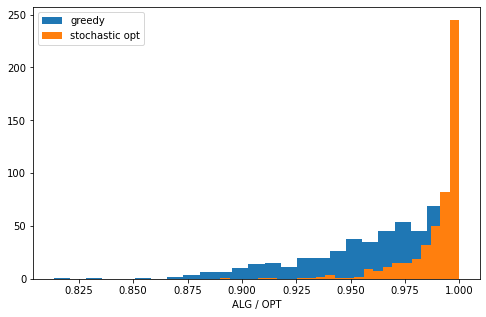

Stochastic opt, mean: 0.990007677519753, std: 0.014383267000633162


In [378]:
plt.figure(figsize=(8,5))
plt.hist(alg_ratios, bins=25, label='greedy')
plt.hist(opt_ratios, bins=25, label='stochastic opt')
plt.legend()
plt.xlabel('ALG / OPT')
plt.show()

print(f'Stochastic opt, mean: {np.mean(opt_ratios)}, std: {np.std(opt_ratios)}')

### BA(affinity=3)

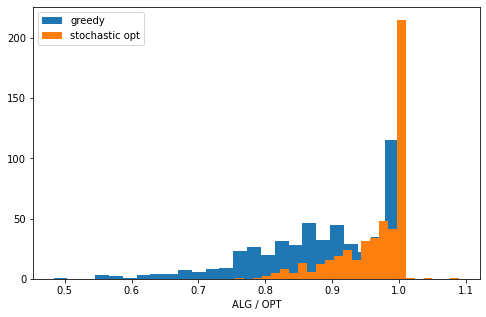

Stochastic opt, mean: 0.9627635544016148, std: 0.050551507587096034


In [366]:
plt.figure(figsize=(8,5))
plt.hist(alg_ratios, bins=25, label='greedy')
plt.hist(opt_ratios, bins=25, label='stochastic opt')
plt.legend()
plt.xlabel('ALG / OPT')
plt.show()

print(f'Stochastic opt, mean: {np.mean(opt_ratios)}, std: {np.std(opt_ratios)}')

### Erdos-Reyni(p=0.5)

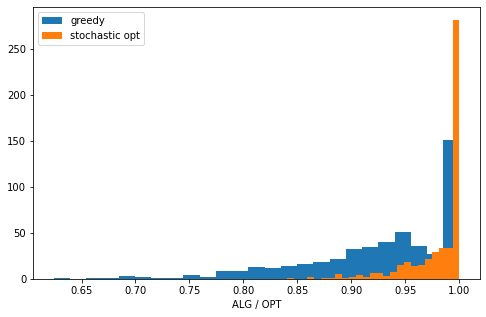

Stochastic opt, mean: 0.9828452472395037, std: 0.02714321448492854


In [352]:
plt.figure(figsize=(8,5))
plt.hist(alg_ratios, bins=25, label='greedy')
plt.hist(opt_ratios, bins=25, label='stochastic opt')
plt.legend()
plt.xlabel('ALG / OPT')
plt.show()

print(f'Stochastic opt, mean: {np.mean(opt_ratios)}, std: {np.std(opt_ratios)}')

### Complete graph

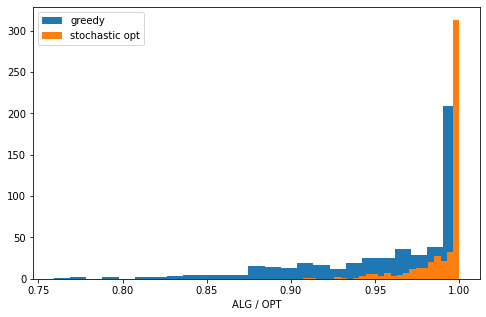

In [325]:
plt.figure(figsize=(8,5))
plt.hist(alg_ratios, bins=25, label='greedy')
plt.hist(opt_ratios, bins=25, label='stochastic opt')
plt.legend()
plt.xlabel('ALG / OPT')
plt.show()


In [335]:
print(f'Stochastic opt, mean: {np.mean(opt_ratios)}, std: {np.std(opt_ratios)}')

Stochastic opt, mean: 0.9910791974711566, std: 0.013339736271277864


## DP scalability testing
- 8-10 x 8-10 | instantaneous
- 11 x 11 | 1s
- 12 x 12 | 2s
- 13 x 13 | 4s
- 14 x 14 | 8s
- 15 x 15 | 20s
- 16 x 16 | 45s